# Исследование факторов ДТП по регионам РФ

## Вступление

ДТП - является одной из частых причин инвалидизации и преждевременной смерти среди трудоспособного населения. Затраты, связанные с ликвидацией последствий ДТП, достигают до 3% внутреннего валового продукта страны. 
Вашему вниманию представлен baseline для выгрузки и дальнейшего анализа данных по ДТП с 2015 по 2023 годы.

Файлы находятся [тут](https://dtp-stat.ru/opendata) в формате geojson.
Ниже представлена структура файлов. 

Адресация файлов в коде сделана под Ubuntu и подобные системы.

# Первая часть

## Получение данных

In [7]:
# Загрузка библиотек

import os
import pandas as pd
# from pandas_geojson import read_geojson
import re
import requests
import matplotlib.pyplot as plt

Вид данных.

In [10]:
# Загрузим страницу по ссылке и запишем данные.
base_url = 'https://dtp-stat.ru/opendata'

hd = {
        'User-Agent': 'Mozilla/5.0 (compatible; U; ABrowse 0.6; Syllable) AppleWebKit/420+ (KHTML, like Gecko)'
      }


response = requests.get(base_url,headers=hd)


# Сохраняем страницу, чтобы не перегружать сервер.
with open('dtp.html', 'wb') as file:
    file.write(response.content)

Используем регулярное выражение для получения данных.

In [13]:
# Получаем список ссылок, для загрузки файлов.

list_for_download = re.findall(r'https:\/\/cms.dtp-stat.ru[\S][^\"\n]+',response.text)

In [8]:
# Функция для загрузки файлов с сайта.

def write_url_to_file(url):

    response = requests.get(url)
#   Добавление пути файла и замена в имени файла дефиса ни нижнее подчеркивание.

    path = f'dtp/' + re.search(r"[\w-]+.geojson", url)[0].replace('-', '_')

#   Запись в файл.
    file = open(path, "wb")
    file.write(response.content)
    file.close()
    return

In [9]:
# Создадим папку для сохранения файлов с сайта и запустим функцию.
if os.path.isdir('dtp') == False:
    os.mkdir('dtp')

for url in list_for_download:    
    write_url_to_file(url)
        

Первая часть - получение данных, выполнена! Теперь эти данные нужно предобработать.

В примере будет показана предобработка одного файла, данную операцию можно сделать с несколькими файлами. Если будет желание, то можно попробовать со всеми файлами.

Далее я проведу повторную загрузку библиотек, так как во второй части мы предполагаем, что все данные у нас получены, поэтому повторно с сайта мы их загружать не будем.

# Вторая часть

## Создание датафреймов

In [17]:
# Загрузка библиотек

import os
import pandas as pd
# from pandas_geojson import read_geojson
import re
import requests
import matplotlib.pyplot as plt
import datetime as dt
import dill as pickle

In [19]:
# Заплатка для Windows и новой библиотеки.

def read_geojson(filename):
    with open(f'{filename}', encoding= 'utf-8') as response:
        geo_json = json.load(response)
    return geo_json

In [21]:
# Прочитаем файлы в дирректории dtp и переведем первый файл в датафрейм
list_file = os.listdir('dtp')

# Посчитаем общее число скачанных файлов.
print(f'Общее число файлов в директории dtp {len(list_file)}.')

geo_json = read_geojson(os.path.join('dtp',list_file[0]))

Общее число файлов в директории dtp 85.


In [23]:
geo_json.keys()

dict_keys(['type', 'features'])

In [25]:
geo_json['type']

'FeatureCollection'

In [27]:
# Смотрим структуру файла.

geo_json['features'][0]

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [61.44946, 69.356067]},
 'properties': {'id': 2774217,
  'tags': ['Дорожно-транспортные происшествия'],
  'light': 'Светлое время суток',
  'point': {'lat': 69.356067, 'long': 61.44946},
  'nearby': [],
  'region': 'Ненецкий АО',
  'scheme': None,
  'address': None,
  'weather': ['Пасмурно'],
  'category': 'Опрокидывание',
  'datetime': '2022-08-29 12:00:00',
  'severity': 'Тяжёлый',
  'vehicles': [{'year': 2020,
    'brand': 'Прочие марки ТС',
    'color': 'Белый',
    'model': 'Прочие марки и модели ТС',
    'category': 'Квадрициклы',
    'participants': [{'role': 'Водитель',
      'gender': 'Мужской',
      'violations': ['Управление ТС лицом, не имеющим права на управление ТС',
       'Эксплуатация незарегистрированного ТС',
       'Нарушение правил применения мотошлема',
       'Несоблюдение требований ОСАГО'],
      'health_status': 'Раненый, находящийся (находившийся) на стационарном лечении',
      'years_of_driv

Структура совпадает с примером.

In [30]:
# Попытка прочитать сразу не удалась.

pd.DataFrame(geo_json).head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


In [32]:
# Используем нормализацию json из бибилотеки pandas - json_normalize

df = pd.json_normalize(geo_json['features'])

# Прочитаем первые пять строк и транспонируем таблицу для удобства.

df.head().T

,0,1,2,3,4
type,Feature,Feature,Feature,Feature,Feature
geometry.type,Point,Point,Point,Point,Point
geometry.coordinates,"[61.44946, 69.356067]","[52.995107, 67.640628]","[53.103822, 67.667859]","[53.111397, 67.6666]","[56.498694, 67.193771]"
properties.id,2774217,2774218,2566691,2557589,2557591
properties.tags,[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия],[Дорожно-транспортные происшествия]
properties.light,Светлое время суток,Сумерки,"В темное время суток, освещение включено","В темное время суток, освещение включено",Светлое время суток
properties.point.lat,69.356067,67.640628,67.667859,67.6666,67.193771
properties.point.long,61.44946,52.995107,53.103822,53.111397,56.498694
properties.nearby,[],"[Многоквартирные жилые дома, Нерегулируемый пе...","[Жилые дома индивидуальной застройки, Остановк...","[Многоквартирные жилые дома, Выезд с прилегающ...",[Нерегулируемый перекрёсток неравнозначных ули...
properties.region,Ненецкий АО,Ненецкий АО,Ненецкий АО,Ненецкий АО,Ненецкий АО


In [34]:
# Смотрим общую информацию.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   type                               273 non-null    object 
 1   geometry.type                      273 non-null    object 
 2   geometry.coordinates               273 non-null    object 
 3   properties.id                      273 non-null    int64  
 4   properties.tags                    273 non-null    object 
 5   properties.light                   273 non-null    object 
 6   properties.point.lat               273 non-null    float64
 7   properties.point.long              273 non-null    float64
 8   properties.nearby                  273 non-null    object 
 9   properties.region                  273 non-null    object 
 10  properties.scheme                  228 non-null    object 
 11  properties.address                 203 non-null    object 

Слишком длинные названия столбцов. Укоротим и удалим первые два столбца.

In [37]:
df = df.drop([col for col in df.columns if 'type' in col], axis =1)
df.columns = [col.split('.')[-1] for col in df.columns]
df.columns

Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')

Еще раз посмотрим на данные представленные в формате geojson.

    "id"  # идентификатор
    "tags"  # показатели с официального сайта ГИБДД
    "light"  # время суток
    "point"  # координаты
    "nearby"  # объекты рядом
    "region" # город/район
    "address" # адрес
    "weather"  # погода
    "category"  # тип ДТП
    "datetime"  # дата и время
    "severity" # тяжесть ДТП/вред здоровью
    "vehicles": [  # участники – транспортные средства
        {
            "year":
            2010,  # год производства транспортного средства
            "brand":
            "ВАЗ",  # марка транспортного средства
            "color":
            "Иные цвета",  # цвет транспортного средства
            "model":
            "Priora",  # модель транспортного средства
            "category":
            "С-класс (малый средний, компактный) до 4,3 м",  # категория транспортного средства
            "participants": [  # участники внутри транспортных средств
                {
                    "role": "Водитель",  # роль участника
                    "gender": "Женский",  # пол участника
                    "violations": [],  # нарушения правил участником
                    "health_status":
                    "Раненый, находящийся...",  # состояние здоровья участника
                    "years_of_driving_experience" # стаж вождения участника (только у водителей)
                }
            ]
        },
    ],
    "dead_count" # кол-во погибших в ДТП
    "participants" # участники без транспортных средств (описание, как у участников внутри транспортных средств)
    "injured_count" # кол-во раненых в ДТП
    "parent_region" # родительский регион (основной)
    "road_conditions" # состояние дорожного покрытия
    "participants_count" # кол-во участников ДТП
    "participant_categories" # категории участников


Для начала посмотрим, что у нас получилось в общем датафрейме.

Обратим внимание, что часть данных находится в форматах json или list. Эти данные необходимо выделить в отдельный датафрейм (для json) или перевести в более удобный формат(list).

In [27]:
# Создадим функция для исследования данных (Первый шаг EDA).

def first_look_data(data):
    display(data.head())
    print('Колонки')
    print(data.columns)
#     Данный print позволяет красиво выделять данные, 
#     не набирая при этом 50 раз * или -)))

    print(50*'-')
    print('Содержимое колонок')
    print(20*'*')
    
# Многие из вас используют data.columns,
# но можно и так.
    for col in data:
        print(col)
# Не все колонки могут быть прочитаны
# unique и nunique
        try:
            print(data[col].unique())
            print(data[col].nunique())
            
            
        except TypeError:
            print('Списковое исключение')
            
            print(data[col][:5])
            
           
    
        print(20*'*')
    print('Общая информация')
    print(data.info())
        
    print(50*"-")
    print('Пропуски')
    print(data.isna().sum())
    print(50*"-")

In [28]:
first_look_data(df)

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,...,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[61.44946, 69.356067]",2774217,[Дорожно-транспортные происшествия],Светлое время суток,69.356067,61.449460,[],Ненецкий АО,None,None,...,2022-08-29 12:00:00,Тяжёлый,"[{'year': 2020, 'brand': 'Прочие марки ТС', 'c...",0,[],1,Ненецкий автономный округ,[Загрязненное],1,[Все участники]
1,"[52.995107, 67.640628]",2774218,[Дорожно-транспортные происшествия],Сумерки,67.640628,52.995107,"[Многоквартирные жилые дома, Нерегулируемый пе...",Ненецкий АО,700,"г Нарьян-Мар, ул Профессора Г.А.Чернова, 7",...,2022-08-26 19:25:00,Легкий,"[{'year': 2017, 'brand': 'HYUNDAI', 'color': '...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Ненецкий автономный округ,[Сухое],2,"[Пешеходы, Все участники]"
2,"[53.103822, 67.667859]",2566691,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",67.667859,53.103822,"[Жилые дома индивидуальной застройки, Остановк...",Ненецкий АО,600,"рп Искателей, г. Нарьян-Мар - п. Искателей, 4 км",...,2021-04-01 03:00:00,С погибшими,"[{'year': 2005, 'brand': 'ВАЗ', 'color': 'Сини...",1,[],0,Ненецкий автономный округ,"[Недостатки зимнего содержания, Гололедица]",1,[Все участники]
3,"[53.111397, 67.6666]",2557589,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",67.666600,53.111397,"[Многоквартирные жилые дома, Выезд с прилегающ...",Ненецкий АО,200,"рп Искателей, ул Юбилейная, 80 А",...,2021-03-29 20:43:00,Тяжёлый,"[{'year': 2014, 'brand': 'RENAULT', 'color': '...",0,[],2,Ненецкий автономный округ,"[Недостатки зимнего содержания, Гололедица]",3,[Все участники]
4,"[56.498694, 67.193771]",2557591,[Дорожно-транспортные происшествия],Светлое время суток,67.193771,56.498694,[Нерегулируемый перекрёсток неравнозначных ули...,Ненецкий АО,410,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",...,2021-03-22 15:00:00,Легкий,"[{'year': 2013, 'brand': 'КАМАЗ', 'color': 'Си...",0,[],1,Ненецкий автономный округ,[Обработанное противогололедными материалами],2,[Все участники]


Колонки
Index(['coordinates', 'id', 'tags', 'light', 'lat', 'long', 'nearby', 'region',
       'scheme', 'address', 'weather', 'category', 'datetime', 'severity',
       'vehicles', 'dead_count', 'participants', 'injured_count',
       'parent_region', 'road_conditions', 'participants_count',
       'participant_categories'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
coordinates
Списковое исключение
0     [61.44946, 69.356067]
1    [52.995107, 67.640628]
2    [53.103822, 67.667859]
3      [53.111397, 67.6666]
4    [56.498694, 67.193771]
Name: coordinates, dtype: object
********************
id
[2774217 2774218 2566691 2557589 2557591 2548878 2882427 2773999 2784575
 2784577 2668027 2668028 2842085 2842086 2842087 2842088 2733732 2557590
 2548876 2813091 2784576 2719346 2719344 2719345 2719347 2719348 2719349
 2719350 2719351 2922336 2772772 2772771 2747987 2747988 2747989 2760253
 2813570 2761123 2867616 2830139 2830

Основные проблемы:
- Есть списки;
- Есть json;
- Есть столбец scheme, которого нет в описании.
- Столбец даты не приведен к нужному формату.

Решаем проблемы:
- Пробуем разделить списки;
- Разделяем json;
- Оставляем scheme, приведя пропуски к единому типу.
- Приводим столбец даты в нужный формат.

Теперь выделим в отдельный датафреймы json структуры.

Для чего используем json_normalize.

In [31]:
# Пишем функцию.

def normalize_json_to_data(data, col):
    
    data_out = pd.json_normalize(data.explode(col)[col])
    
    
#     Все таблицы связаны между собой через id родительской таблицы.

    data_out = pd.concat([
        pd.DataFrame(data.explode(col)['id'].values, columns=['id']),
        data_out
    ],
                            axis=1)
    return data_out

In [32]:
# Датафрейм для машин.

df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

# Датафрейм для пассажиров машин.

df_vehicles_participants = normalize_json_to_data(
    df_vehicles, 'participants').reset_index(drop=True)

# Датафрейм для пешеходов.
# Дополнительно удалим все пустые строки, так как там нет пешеходов.
df_footer = normalize_json_to_data(
    df, 'participants').dropna().reset_index(drop=True)

In [33]:
first_look_data(df_vehicles)

,id,year,brand,color,model,category,participants
0,2774217,2020.0,Прочие марки ТС,Белый,Прочие марки и модели ТС,Квадрициклы,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
1,2774218,2017.0,HYUNDAI,Черный,Solaris,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Женский', 'vi..."
2,2566691,2005.0,ВАЗ,Синий,ВАЗ 2131 и модификации,"В-класс (малый) до 3,9 м","[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."
3,2557589,2014.0,RENAULT,Черный,Logan,"В-класс (малый) до 3,9 м","[{'role': 'Пассажир', 'gender': 'Женский', 'vi..."
4,2557589,2011.0,GREAT WALL,Черный,Прочие модели Great Wall,Прочие легковые автомобили,"[{'role': 'Водитель', 'gender': 'Мужской', 'vi..."


Колонки
Index(['id', 'year', 'brand', 'color', 'model', 'category', 'participants'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2774217 2774218 2566691 2557589 2557591 2548878 2882427 2773999 2784575
 2784577 2668027 2668028 2842085 2842086 2842087 2842088 2733732 2557590
 2548876 2813091 2784576 2719346 2719344 2719345 2719347 2719348 2719349
 2719350 2719351 2922336 2772772 2772771 2747987 2747988 2747989 2760253
 2813570 2761123 2867616 2830139 2830140 2830141 2830143 2804374 2853399
 2772770 2909488 2895837 2830142 2867615 2867617 2830144 2940152 2456072
 2456078 2456095 2456112 2456126 2456132 2456133 2456147 2456167 2456202
 2456207 2456215 2456220 2456222 2456245 2456258 2456266 2456073 2456111
 2456157 2456240 2456256 2456257 2456259 2456260 2456261 2456263 2456264
 2456265 2456267 2456268 2456068 2456069 2456070 2456071 2456074 2456077
 2456079 2456080 2456081 2456082 2456083 2456084 2456085 2456086 2456087
 2

In [34]:
first_look_data(df_vehicles_participants)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2774217,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на упра...","Раненый, находящийся (находившийся) на стацион...",NaN
1,2774218,Водитель,Женский,[Нарушение правил проезда пешеходного перехода],Не пострадал,8.0
2,2566691,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,Скончался на месте ДТП до приезда скорой медиц...,4.0
3,2557589,Пассажир,Женский,[Нарушение правил применения ремней безопаснос...,"Раненый, находящийся (находившийся) на стацион...",NaN
4,2557589,Водитель,Женский,[Нарушение водителем правил применения ремней ...,"Раненый, находящийся (находившийся) на амбулат...",3.0


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2774217 2774218 2566691 2557589 2557591 2548878 2882427 2773999 2784575
 2784577 2668027 2668028 2842085 2842086 2842087 2842088 2733732 2557590
 2548876 2813091 2784576 2719346 2719344 2719345 2719347 2719348 2719349
 2719350 2719351 2922336 2772772 2772771 2747987 2747988 2747989 2760253
 2813570 2761123 2867616 2830139 2830140 2830141 2830143 2804374 2853399
 2772770 2909488 2895837 2830142 2867615 2867617 2830144 2940152 2456072
 2456078 2456095 2456112 2456126 2456132 2456133 2456147 2456167 2456202
 2456207 2456215 2456220 2456222 2456245 2456258 2456266 2456073 2456111
 2456157 2456240 2456256 2456257 2456259 2456260 2456261 2456263 2456264
 2456265 2456267 2456268 2456068 2456069 2456070 2456071 2456074 2456077
 2456079 2456080 2456081 2456082 2456083 2456

In [35]:
first_look_data(df_footer)

,id,role,gender,violations,health_status
0,2774218,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...
1,2773999,Пешеход,Женский,[Переход через проезжую часть вне пешеходного ...,"Раненый, находящийся (находившийся) на стацион..."
2,2842086,Пешеход,Мужской,[Иные нарушения],Получил телесные повреждения с показанием к ле...
3,2842088,Пешеход,Женский,[],Получил телесные повреждения с показанием к ле...
4,2842088,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2774218 2773999 2842086 2842088 2733732 2719349 2922336 2909488 2830142
 2456133 2456167 2456215 2456222 2456256 2456259 2456260 2456263 2456267
 2456068 2456080 2456083 2456090 2456092 2456100 2456109 2456110 2456116
 2456128 2456130 2456131 2456139 2456143 2456145 2456152 2456154 2456156
 2456168 2456171 2456173 2456175 2456178 2456185 2456189 2456191 2456200
 2456203 2456204 2456216 2456219 2456227 2456246 2456253 2491637 2491640
 2456075 2456089 2456107 2456124 2456209 2579059 2456097 2505696 2456255
 2456162 2456163 2456101 2456262 2456174 2456242 2630173]
70
********************
role
['Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
2
********************
gender
['Мужской' 'Женский']
2
********************
vi

Наши датафреймы почти готовы. Дальнейшую предобработку покажу ниже.

---



# Списки

Начнем со списков. Посмотрим, что в себе содержат списки.

Как видно, списки могут содержат до 58 значений, возьмем в дальнейшем для разделения погоду. А сейчас переведем даты в формат datetime (само название этого требует).

In [40]:
# Перевод в формат дат.
df['datetime'] = pd.to_datetime(df['datetime'])

Теперь посмотрим общую информацию по всем датафреймам и внешний вид полученных данных. Дадим расшифровку столбцам.

## df

* 'coordinates' - координаты  , 
* 'id' - идентификатор, 
* 'tags' - показатели с официального сайта ГИБДД, 
* 'light' - время суток, 
* 'lat' - широта, 
* 'long' - долгота, 
* 'nearby' - объекты рядом, 
* 'region' - город/район и т.д.,
* 'scheme' - схема ДТП (нет в описании), 
* 'address' - адрес ДТП, 
* 'weather' - погодные условия, 
* 'category' - тип ДТП 
* 'datetime' - дата и время ДТП, 
* 'severity' - тяжесть состояния,
* 'vehicles' транспортное средство, 
* 'dead_count' - погибшие, 
* 'participants' - участники в транспортном средстве, 
* 'injured_count' - количество пострадавших,
* 'parent_region' - центральный регион, 
* 'road_conditions' - условия дороги, 
* 'participants_count' - количество участников ДТП,
* 'participant_categories' - категории участников

In [44]:
# Удяляем участников в транспортном средстве.

df_vehicles = df_vehicles.drop(['participants'],axis=1)

## df_vehicles

* id - идентификатор
* year - год выпуска
* brand - а/м компания
* color - цвет а/м
* model - модель машины
* category - категория транспортного средства

In [47]:
df_vehicles_participants.info()
df_vehicles_participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           536 non-null    int64  
 1   role                         535 non-null    object 
 2   gender                       516 non-null    object 
 3   violations                   535 non-null    object 
 4   health_status                535 non-null    object 
 5   years_of_driving_experience  283 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 25.3+ KB


,id,role,gender,violations,health_status,years_of_driving_experience
0,2774217,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на упра...","Раненый, находящийся (находившийся) на стацион...",NaN
1,2774218,Водитель,Женский,[Нарушение правил проезда пешеходного перехода],Не пострадал,8.0
2,2566691,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,Скончался на месте ДТП до приезда скорой медиц...,4.0
3,2557589,Пассажир,Женский,[Нарушение правил применения ремней безопаснос...,"Раненый, находящийся (находившийся) на стацион...",NaN
4,2557589,Водитель,Женский,[Нарушение водителем правил применения ремней ...,"Раненый, находящийся (находившийся) на амбулат...",3.0


## df_vehicles_participants

* id - идентификатор
* role - роль в транспортном средстве
* gender - половая пренадлежность
* violations - нарушение
* health_status - вред здоровью
* years_of_driving_experience - стаж вождения

In [50]:
df_footer.info()
df_footer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             74 non-null     int64 
 1   role           74 non-null     object
 2   gender         74 non-null     object
 3   violations     74 non-null     object
 4   health_status  74 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.0+ KB


,id,role,gender,violations,health_status
0,2774218,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...
1,2773999,Пешеход,Женский,[Переход через проезжую часть вне пешеходного ...,"Раненый, находящийся (находившийся) на стацион..."
2,2842086,Пешеход,Мужской,[Иные нарушения],Получил телесные повреждения с показанием к ле...
3,2842088,Пешеход,Женский,[],Получил телесные повреждения с показанием к ле...
4,2842088,Пешеход,Мужской,[],Получил телесные повреждения с показанием к ле...


## df_footer

* id - идентификатор
* role - роль
* gender - половая пренадлежность
* violations - нарушение
* health_status - вред здоровью

Таким образом мы получили 4 датафрейма:

df - общий датафрейм по ДТП.

* 'coordinates' - координаты  , 
* 'id' - идентификатор, 
* 'tags' - показатели с официального сайта ГИБДД, 
* 'light' - время суток, 
* 'lat' - широта, 
* 'long' - долгота, 
* 'nearby' - объекты рядом, 
* 'region' - город/район и т.д.,
* 'scheme' - схема ДТП (нет в описании), 
* 'address' - адрес ДТП, 
* 'weather' - погодные условия, 
* 'category' - тип ДТП 
* 'datetime' - дата и время ДТП, 
* 'severity' - тяжесть состояния,
* 'vehicles' транспортное средство, 
* 'dead_count' - погибшие, 
* 'participants' - участники в транспортном средстве, 
* 'injured_count' - количество пострадавших,
* 'parent_region' - центральный регион, 
* 'road_conditions' - условия дороги, 
* 'participants_count' - количество участников ДТП,
* 'participant_categories' - категории участников

df_vehicles - данные по транспортным средствам.

* id - идентификатор
* year - год выпуска
* brand - а/м компания
* color - цвет а/м
* model - модель машины
* category - категория транспортного средства

df_vehicles_participants - данные по пассажирам ТС.

* id - идентификатор
* role - роль в транспортном средстве
* gender - половая принадлежность
* violations - нарушение
* health_status - вред здоровью
* years_of_driving_experience - стаж вождения

df_footer - пешеходы.

* id - идентификатор
* role - роль
* gender - половая принадлежность
* violations - нарушение
* health_status - вред здоровью

In [54]:
#  Объединим таблицы df_footer и df_vehicles_participants


df_foot_part = pd.concat([df_vehicles_participants,df_footer]).copy().reset_index(drop=True)

In [55]:
first_look_data(df_foot_part)

,id,role,gender,violations,health_status,years_of_driving_experience
0,2774217,Водитель,Мужской,"[Управление ТС лицом, не имеющим права на упра...","Раненый, находящийся (находившийся) на стацион...",NaN
1,2774218,Водитель,Женский,[Нарушение правил проезда пешеходного перехода],Не пострадал,8.0
2,2566691,Водитель,Мужской,[Нарушение правил расположения ТС на проезжей ...,Скончался на месте ДТП до приезда скорой медиц...,4.0
3,2557589,Пассажир,Женский,[Нарушение правил применения ремней безопаснос...,"Раненый, находящийся (находившийся) на стацион...",NaN
4,2557589,Водитель,Женский,[Нарушение водителем правил применения ремней ...,"Раненый, находящийся (находившийся) на амбулат...",3.0


Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2774217 2774218 2566691 2557589 2557591 2548878 2882427 2773999 2784575
 2784577 2668027 2668028 2842085 2842086 2842087 2842088 2733732 2557590
 2548876 2813091 2784576 2719346 2719344 2719345 2719347 2719348 2719349
 2719350 2719351 2922336 2772772 2772771 2747987 2747988 2747989 2760253
 2813570 2761123 2867616 2830139 2830140 2830141 2830143 2804374 2853399
 2772770 2909488 2895837 2830142 2867615 2867617 2830144 2940152 2456072
 2456078 2456095 2456112 2456126 2456132 2456133 2456147 2456167 2456202
 2456207 2456215 2456220 2456222 2456245 2456258 2456266 2456073 2456111
 2456157 2456240 2456256 2456257 2456259 2456260 2456261 2456263 2456264
 2456265 2456267 2456268 2456068 2456069 2456070 2456071 2456074 2456077
 2456079 2456080 2456081 2456082 2456083 2456




df_foot_part - данные по пассажирам ТС и пешеходам.

* id - идентификатор
* role - роль в ДТП
* gender - половая принадлежность
* violations - нарушение
* health_status - вред здоровью
* years_of_driving_experience - стаж вождения

## Работа со списками.

Для начала посмотрим максимальное количество элементов в списке для каждого столбца.

In [59]:
# Разделим самые простые списки.



for col in df:
    
# Важно, чтобы в списках не затерялся json формат.

    if col not in ['vehicles', 'participants']:
        
#  Здесь я перестраховался)))

        try:
            print(f'Столбец {col}')
            #  explode разделяет list
            print(f'Уникальные значения {df.explode(col)[col].unique()}')
            
            print(f'Всего {df.explode(col)[col].nunique()}')
            print(50*'*')
        except:
            print(50*'-')        

Столбец coordinates
Уникальные значения [61.44946 69.356067 52.995107 67.640628 53.103822 67.667859 53.111397
 67.6666 56.498694 67.193771 53.051348 67.653941 53.0447 67.6452 53.117663
 67.677132 52.178707 67.582625 53.106633 67.660944 55.948467 67.315628
 53.074821 67.666207 53.0056 67.6377 53.1186 67.666 53.0612 67.638 53.0114
 67.6368 53.06772 67.66054 56.667137 67.192166 52.976418 67.639619 53.6107
 67.8372 52.976439 67.639628 56.245752 67.242043 53.045779 67.64681
 53.12645 67.667566 52.985762 67.636811 53.043001 67.642982 53.0461
 67.6419 53.056744 67.657788 53.087225 67.666995 53.0352 53.2528 67.6264
 53.128413 67.669751 53.0992 67.613274 49.033366 67.657518 53.104005
 67.671952 53.123317 67.664541 53.001823 67.640652 53.969736 67.933235
 51.137958 67.039669 53.0532 67.6159 55.1115 67.3659 53.6109 67.8449
 53.015 67.6254 55.731164 67.417464 52.8819 67.6362 47.746153 66.732308
 52.9952 67.636 52.9851 67.6369 53.0042 67.6388 53.074651 67.6278
 53.122233 67.663346 53.0072 67.645 53

In [60]:
# Псчитаем максимальное количество элемнтов в списковых исключениях
# и посмотрим их максимальное значение.

def count_max_elemets_from_list_except(data):
    
    
    for col in data:
        try:
            data[col].unique()
            
        except TypeError:
            print(col)
            print('Списковое исключение - max значение')
            try:
                print(data[col].apply(lambda x: len(x)).max())
                print('Всего -',data.explode(col)[col].nunique())
            except TypeError:
                print('JSON')
                
    return   

In [61]:
count_max_elemets_from_list_except(df)

coordinates
Списковое исключение - max значение
2
Всего - 526
tags
Списковое исключение - max значение
3
Всего - 3
nearby
Списковое исключение - max значение
5
Всего - 36
weather
Списковое исключение - max значение
2
Всего - 8
vehicles
Списковое исключение - max значение
3
JSON
participants
Списковое исключение - max значение
2
JSON
road_conditions
Списковое исключение - max значение
5
Всего - 30
participant_categories
Списковое исключение - max значение
3
Всего - 5


Как обещал, возьмем погоду.

In [63]:
# Этот список будет ключом к индексам полученным из наших данных.

my_list = list(df.explode('weather')['weather'].unique())

my_list

['Пасмурно',
 'Ясно',
 'Метель',
 'Снегопад',
 'Дождь',
 'Температура ниже -30С',
 'Ураганный ветер',
 'Туман']

000000000

012345678

Можно взять индексы списка перевести в строку.

In [65]:
# Функция по переводу списка.

def return_w(row):
    # Индекс в строк будет соответсвовать номеру в списке.
    # 0 - нет признака, 1 есть признак.
    # Создадим список из 0 в строчном формате.
    
    number_list = ['0' for i in range(len(my_list))]
    
# Если значение в строке больше нуля то заменяем 0 значения 1 по индексу
    
    if len(row['weather']) >0:
        
        index_list = [my_list.index(i) for i in row['weather']]
        
        for ind in index_list:
            number_list[ind] = '1'
            
# Возвращаем данные в виде строки, разделенной запятыми.        
    return ','.join(number_list)



In [66]:
# Посчитаем полученные значения.

weather_df_count = df.apply(return_w, axis=1).value_counts()

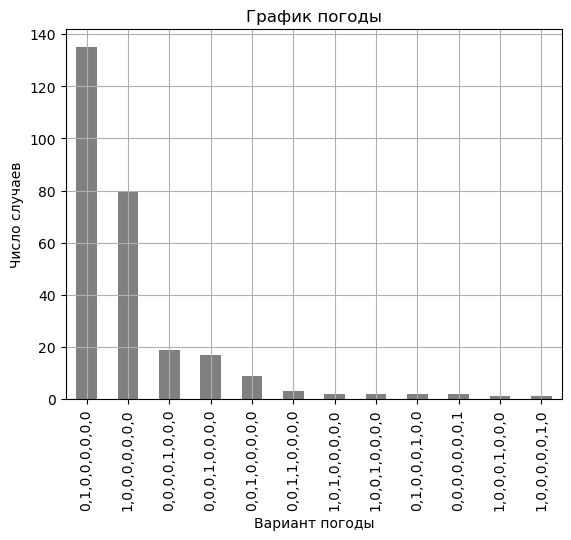

In [67]:
# Построим график.

weather_df_count.plot(kind='bar', grid=True, color = 'grey')
plt.title('График погоды')
plt.xlabel('Вариант погоды')
plt.ylabel('Число случаев');

График сырой, можно и лучше. Чаще всего указывают пасмурную и ясную погоду.

Имеет смысл перевести все показатели в ясную и пасмурную погоду. Учитывая дополнительные факторы.

Для упрощения работы можно перевести все данные в ясную и пасмурную погоду.
Также эти данные можно разделить по типу one hot encoding.

In [70]:
# Подготовим датафрейм с погодой для OHE.

weather_ohe = pd.DataFrame()

weather_ohe['id'] = df['id'].copy()

In [71]:
weather_ohe[my_list] = df.apply(return_w,
                                    axis=1).str.split(',',
                                                      expand=True).astype(int)

weather_ohe.info()
weather_ohe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   id                     273 non-null    int64
 1   Пасмурно               273 non-null    int64
 2   Ясно                   273 non-null    int64
 3   Метель                 273 non-null    int64
 4   Снегопад               273 non-null    int64
 5   Дождь                  273 non-null    int64
 6   Температура ниже -30С  273 non-null    int64
 7   Ураганный ветер        273 non-null    int64
 8   Туман                  273 non-null    int64
dtypes: int64(9)
memory usage: 19.3 KB


,id,Пасмурно,Ясно,Метель,Снегопад,Дождь,Температура ниже -30С,Ураганный ветер,Туман
0,2774217,1,0,0,0,0,0,0,0
1,2774218,0,1,0,0,0,0,0,0
2,2566691,0,1,0,0,0,0,0,0
3,2557589,1,0,0,0,0,0,0,0
4,2557591,0,1,0,0,0,0,0,0


In [72]:
# Посмотрим описательные статистики.

weather_ohe.describe().T

,count,mean,std,min,25%,50%,75%,max
id,273.0,2.525105e+06,131322.919527,2456068.0,2456136.0,2456204.0,2491640.0,2940152.0
Пасмурно,273.0,3.150183e-01,0.465376,0.0,0.0,0.0,1.0,1.0
Ясно,273.0,5.018315e-01,0.500915,0.0,0.0,1.0,1.0,1.0
Метель,273.0,5.128205e-02,0.220978,0.0,0.0,0.0,0.0,1.0
Снегопад,273.0,8.058608e-02,0.272698,0.0,0.0,0.0,0.0,1.0
Дождь,273.0,7.326007e-02,0.261041,0.0,0.0,0.0,0.0,1.0
Температура ниже -30С,273.0,7.326007e-03,0.085435,0.0,0.0,0.0,0.0,1.0
Ураганный ветер,273.0,3.663004e-03,0.060523,0.0,0.0,0.0,0.0,1.0
Туман,273.0,7.326007e-03,0.085435,0.0,0.0,0.0,0.0,1.0


Графики

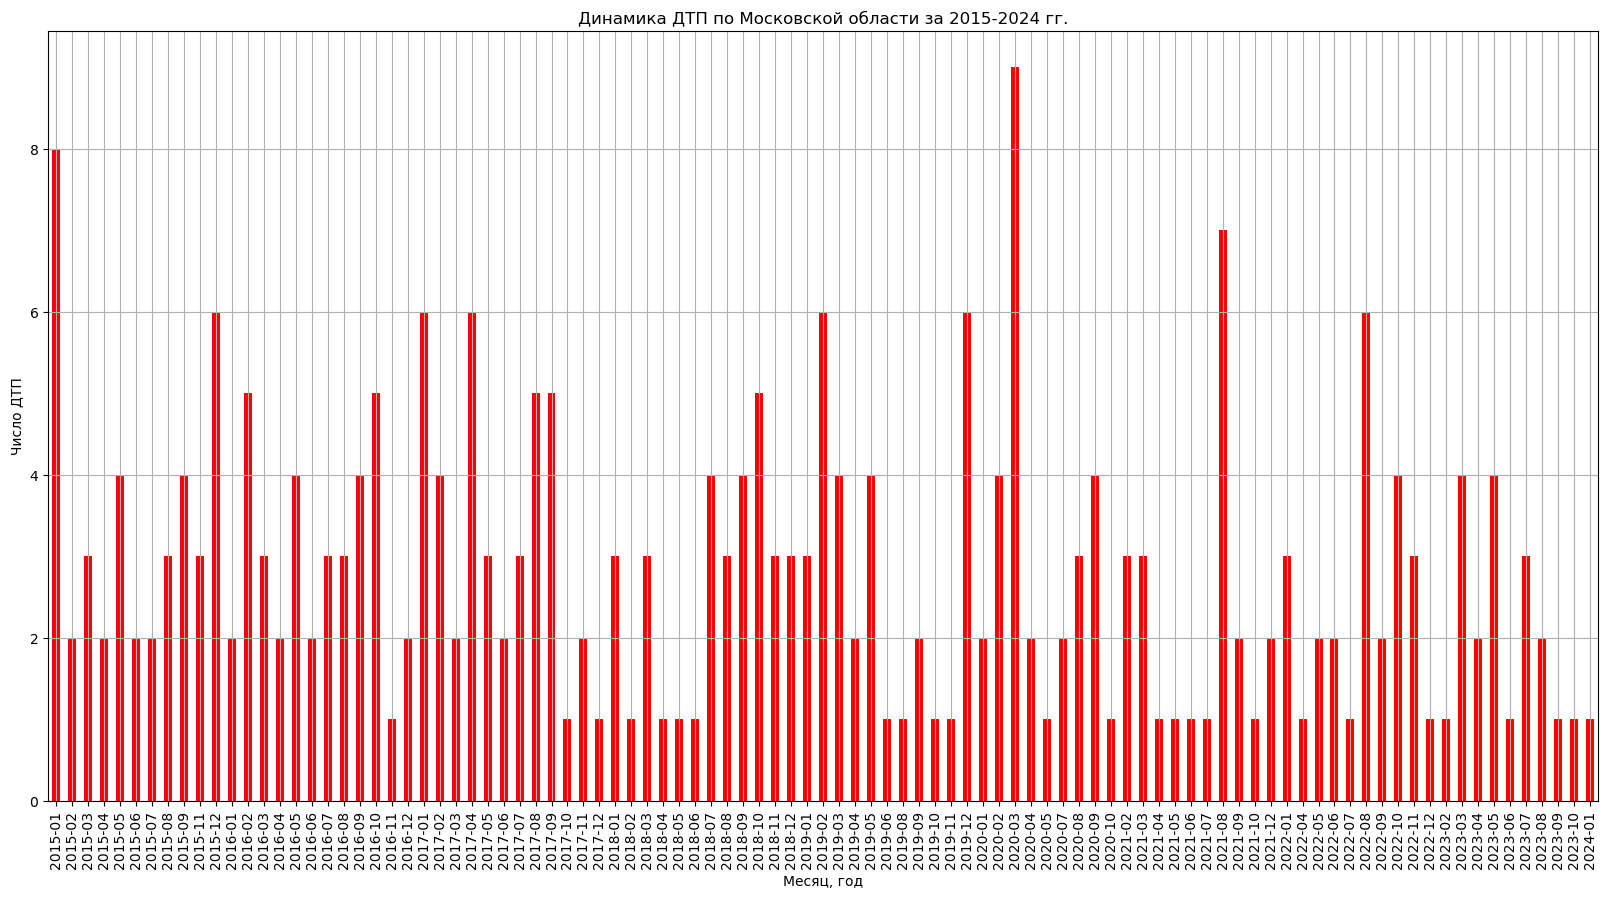

In [74]:
# Посмотрим число ДТП по месяцам.

weather_plot = df['datetime'].dt.to_period("M").sort_values().value_counts(
    sort=False)
weather_plot.plot(kind='bar', grid=True, figsize=[20, 10],color = 'red')
plt.title('Динамика ДТП по Московской области за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

Видна четкая сезонность, и нисходящий тренд по числу ДТП. Похоже, сотрудники ГИБДД не зря едят свой хлеб, но, возможно, это связано с качеством дорог, разметке, качеством авто, законодательной базой. Здесь можно сделать множество предположений. Также можно предположить, что большая часть водителей реже пользуются автомобилями или не пользуются совсем. В летний период увеличивается число водителей-путешественников.

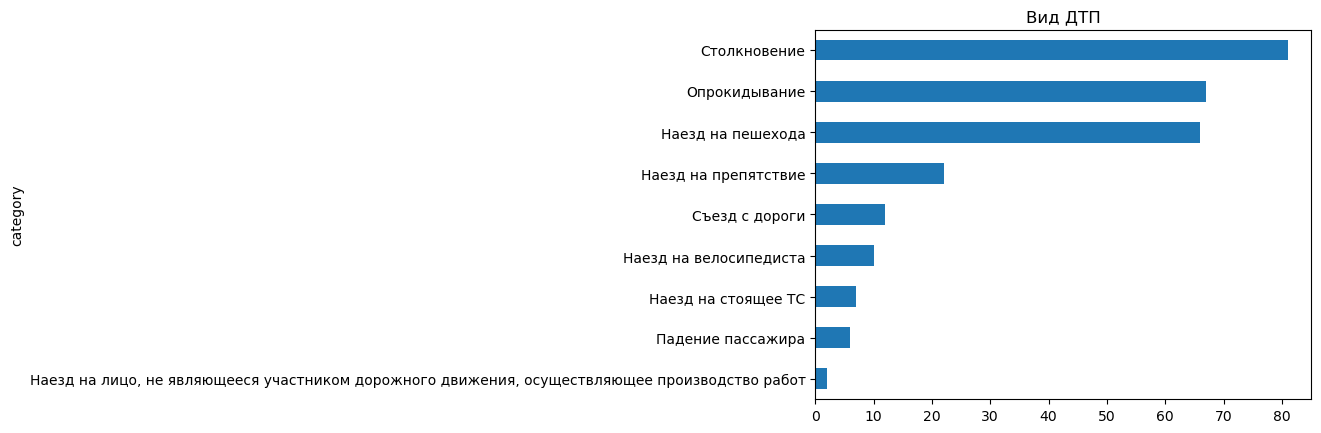

In [76]:
df['category'].value_counts(ascending = True).plot(kind = 'barh')
plt.title('Вид ДТП');

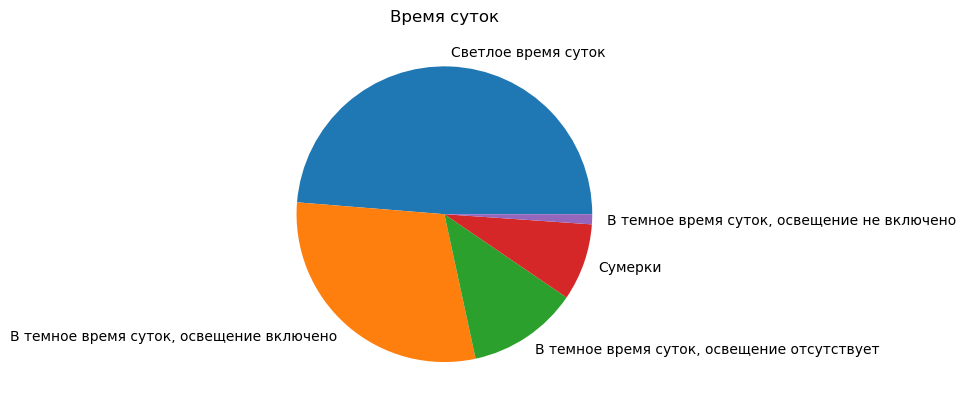

In [77]:
df['light'].value_counts().plot(kind = 'pie', label = '');
plt.title('Время суток');

В светлое время суток чаще ездят, освещение присутствует на крупных магистралях, где более интенсивное движение. Но стоит отметить дороги, где нет освещения. Можно посмотреть категории ДТП в зависимости от типа освещения. Здесь можно провести кластеризацию.(еще один пет-проект, увязывая на тип ДТП).

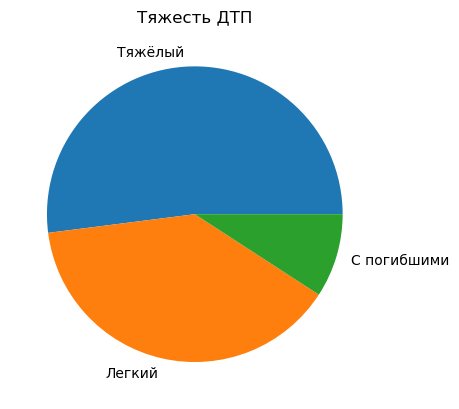

In [79]:
# Посмотрим тяжесть ДТП.

df['severity'].value_counts().plot(kind = 'pie', label = '')
plt.title('Тяжесть ДТП');

In [80]:
# Процентное соотношение.

df['severity'].value_counts(normalize= True).round(2)*100

severity
Тяжёлый        52.0
Легкий         39.0
С погибшими     9.0
Name: proportion, dtype: float64

Почти 2/3 ДТП - являются тяжелыми (есть раненные и с погибшие).

In [82]:
# Посмотрим число погибших.

dead_df = df[['datetime','dead_count', 'injured_count']].copy()

dead_df['datetime_M'] = dead_df['datetime'].dt.to_period("M")

dead_df=dead_df.sort_values(by = ['datetime_M'])

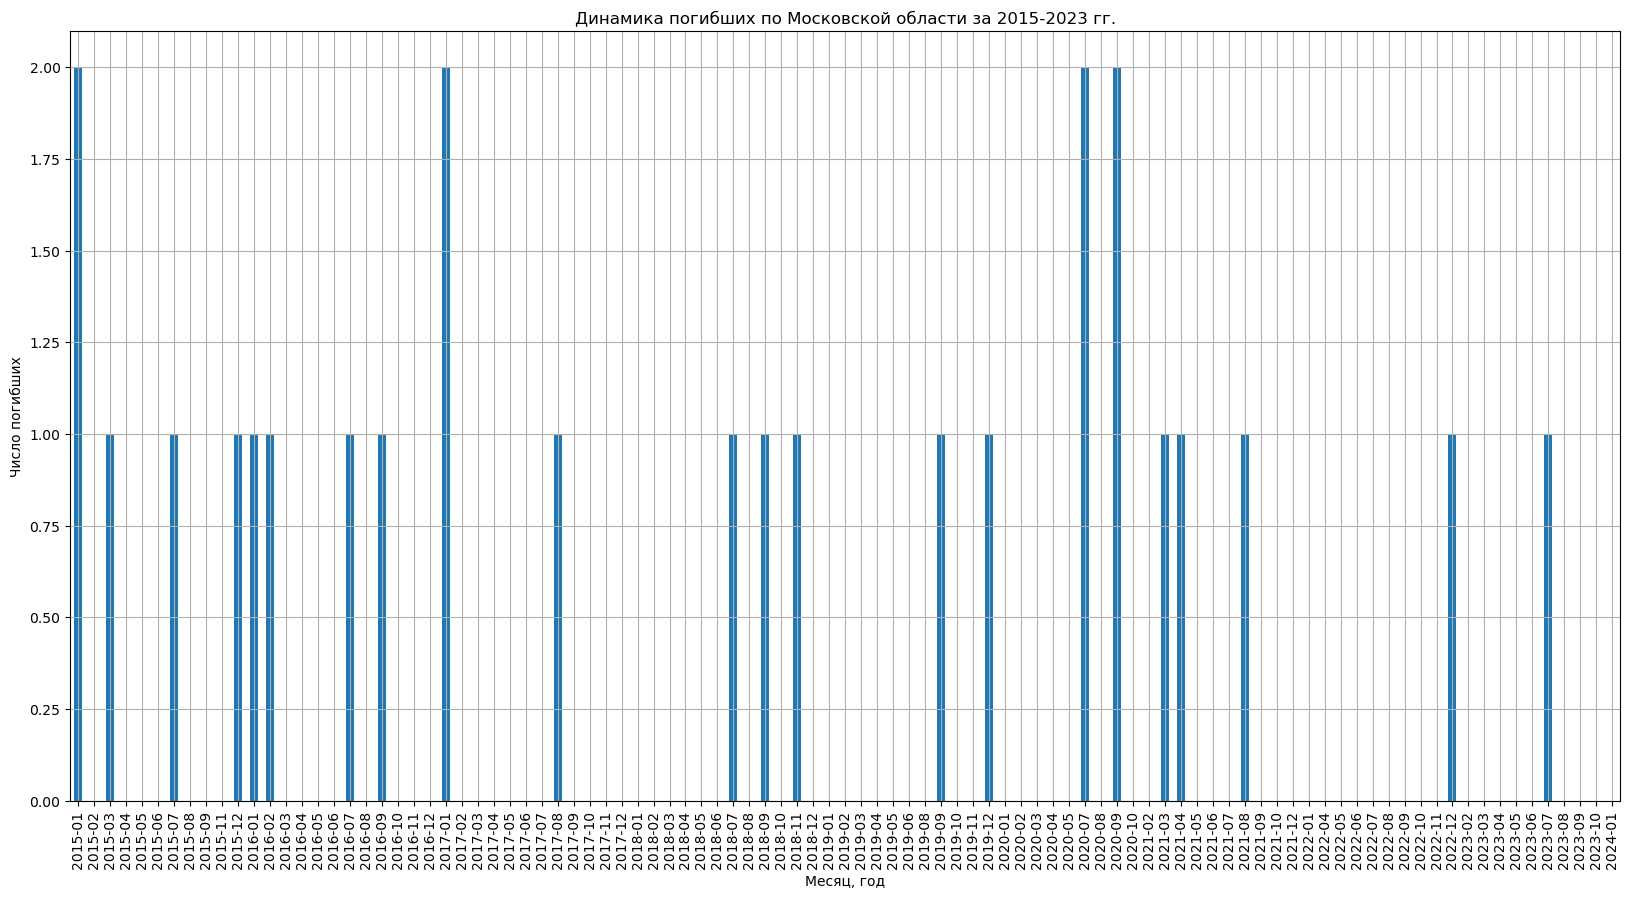

In [83]:
dead_df.groupby('datetime_M')['dead_count'].sum().plot(kind='bar',
                                                       grid=True,
                                                       figsize=[20, 10]
                                                      )

plt.title('Динамика погибших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число погибших');

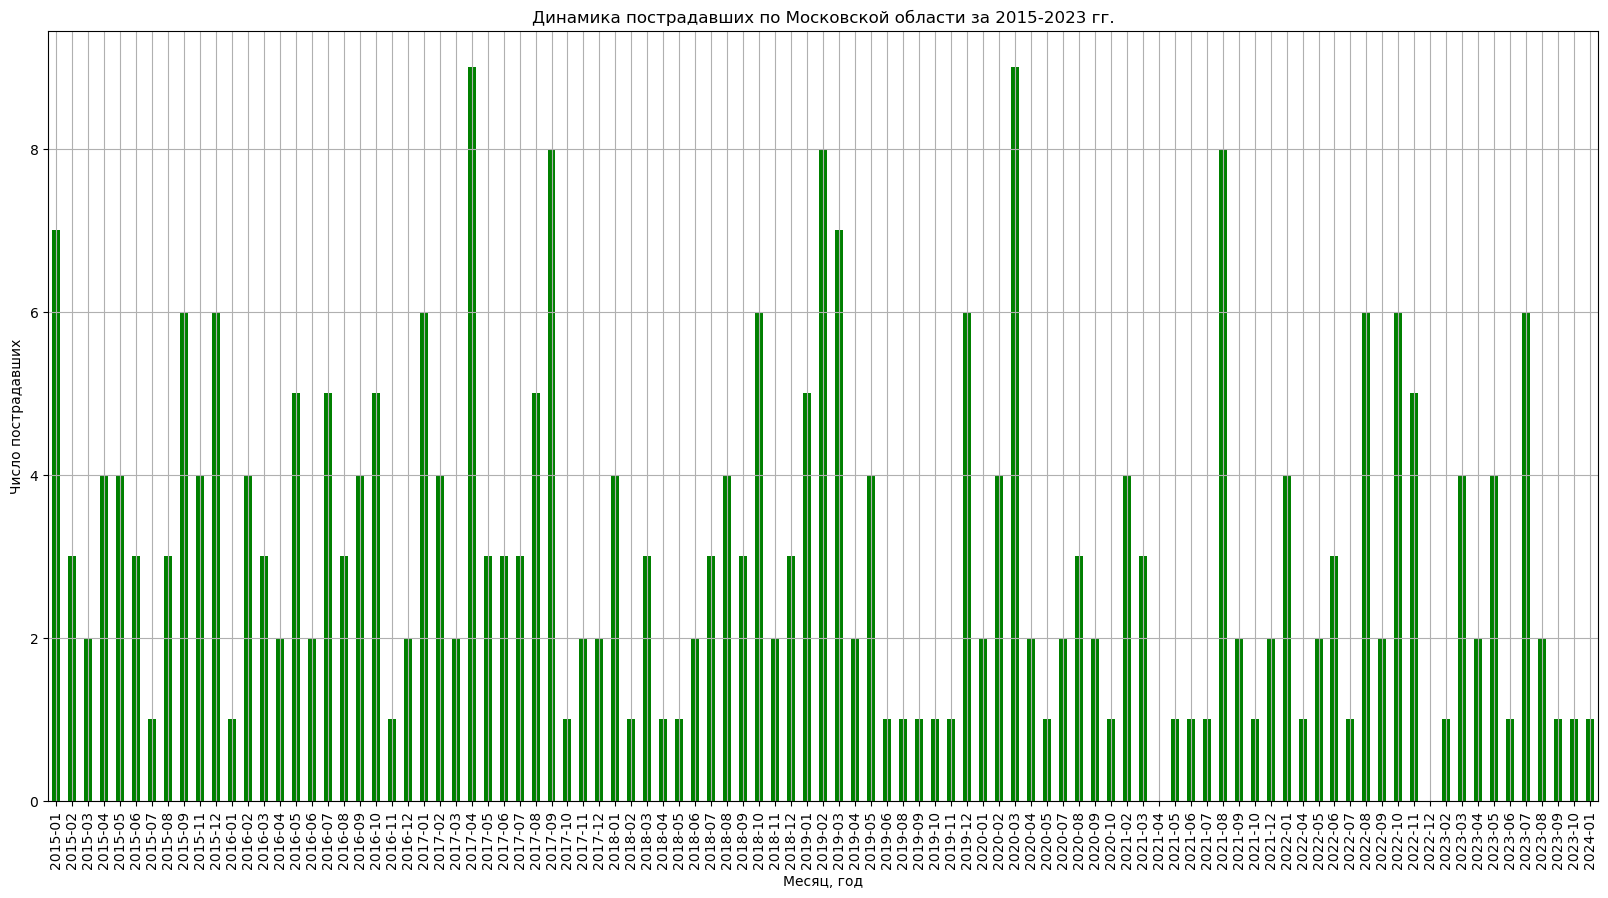

In [84]:
# Смотрим число пострадавших.

dead_df.groupby('datetime_M')['injured_count'].sum().plot(kind='bar',
                                                          grid=True,
                                                          color = 'green',
                                                          figsize=[20, 10])

plt.title('Динамика пострадавших по Московской области за 2015-2023 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число пострадавших');

Как видим количество ДТП, погибших и пострадавших имеют тенденцию к снижению, четкую сезонность. Дальнейшую обработку данных можно делать на ваше усмотрение.)))

# Третья часть

# Рефракторниг кода

Соберем все блоки кода вместе. Попробуем улучшить наш код, написав функцию.

Как видим, при разделении датасета на части, объем потребляемой памяти увеличивается с dead kernel (RIP). Чтобы ядро пережило весь код, воспользуемся локальным пространством функции для сборки датафреймов. Здесь вновь загрузим все библиотеки.

In [89]:
# Загрузка библиотек

import os
import pandas as pd
# from pandas_geojson import read_geojson
import re
import requests
import matplotlib.pyplot as plt
import datetime as dt
import dill as pickle

In [90]:
# Заплатка для Windows и новой библиотеки.

def read_geojson(filename):
    with open(f'{filename}', encoding= 'utf-8') as response:
        geo_json = json.load(response)
    return geo_json

In [91]:
# Пишем функцию по нормализации данных в пандас.


def normalize_json_to_data(data, col):
    
    # Сначала explode потом json_normalize по нужному столбцу.

    data_out = pd.json_normalize(data.explode(col)[col])

    # Все таблицы связаны между собой через id родительской таблицы.

    data_out = pd.concat(
        [pd.DataFrame(data.explode(col)['id'].values, columns=['id']), data_out],
        axis=1)
    
    return data_out

In [92]:
# Прочитаем файлы в дирректории dtp и переведем первый файл в датафрейм
list_file = os.listdir('dtp')


geo_json = read_geojson(os.path.join('dtp',list_file[0]))

In [93]:
# Используем нормализацию json из бибилотеки pandas - json_normalize

df = pd.json_normalize(geo_json['features'])

In [94]:
# Удалим корневые названия и столбцы содержащие type

df = df.drop([col for col in df.columns if 'type' in col], axis =1)

df.columns = [col.split('.')[-1] for col in df.columns]


In [95]:
# Датафрейм для машин.

df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

# Датафрейм для пассажиров машин.

df_vehicles_participants = normalize_json_to_data(
    df_vehicles, 'participants').reset_index(drop=True)

# Датафрейм для пешеходов.
# Дополнительно удалим все пустые строки, так как там нет пешеходов.
df_footer = normalize_json_to_data(
    df, 'participants').dropna().reset_index(drop=True)

In [96]:
# Удяляем участников в транспортном средстве.

df_vehicles = df_vehicles.drop(['participants'], axis=1)

In [97]:
#  Объединим таблицы df_footer и df_vehicles_participants

df_foot_part = pd.concat([df_vehicles_participants,
                          df_footer]).copy().reset_index(drop=True)

In [98]:
# Пишем функцию, которая вернет нам обработанный датафрейм


def return_true_dfs(path):
    geo_json = read_geojson(os.path.join('dtp', path))  # Замена path

    df = pd.json_normalize(geo_json['features'])  # Получаем общий датафрейм

    # Обрабатываем название колонок

    df = df.drop([col for col in df.columns if 'type' in col], axis=1)
    df.columns = [col.split('.')[-1] for col in df.columns]

    # Сразу снижаем размерность id.
    # Чем ниже размерность int, тем меньше ячеек памяти выделяется.
    # Тем меньший диапзон чисел будет хранится, будьте внимательны.
    # NB - не изменяйте размерность float!!!

    df['id'] = df['id'].astype('int32')

    # Датафрейм для машин.

    df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

    # Датафрейм для пассажиров машин.

    df_vehicles_participants = normalize_json_to_data(
        df_vehicles, 'participants').reset_index(drop=True)

    # Датафрейм для пешеходов.

    # Дополнительно удалим все пустые строки, так как там нет пешеходов.

    df_footer = normalize_json_to_data(df,
                                       'participants').reset_index(drop=True)

    # Удяляем участников в транспортном средстве.

    df_vehicles = df_vehicles.drop(['participants'], axis=1)
    df = df.drop(['participants', 'vehicles'], axis=1)

    #  Объединим таблицы df_footer и df_vehicles_participants удалим пустые роли.

    df_foot_part = pd.concat(
        [df_vehicles_participants,
         df_footer]).copy().dropna(subset='role').reset_index(drop=True)

    # Возвращаем полученные датасеты.

    return df, df_vehicles, df_foot_part

In [99]:
data_base, data_vehicles,  df_foot_part = return_true_dfs(list_file[0])

Да, теперь у нас все собирает одна функция. Но вдруг нам понадобится, только один датафрейм.

Давайте обернем функцию, в функцию с условиями.

In [101]:
# _ означает, что данная переменная нам не нужна
# n=1 устанавливает по умолчание значение = 1
def return_df(path, n=1):
    
    # Смысл работе прост, n - переключатель датафрейма.
    if n == 1:
        df, _, _ = return_true_dfs(path)
        
    if n == 2:
        _, df, _ = return_true_dfs(path)
        
    if n == 3:
        _, _, df = return_true_dfs(path)

    return df

In [160]:
return_df(list_file[0]).head()

,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,"[61.44946, 69.356067]",2774217,[Дорожно-транспортные происшествия],Светлое время суток,69.356067,61.449460,[],Ненецкий АО,None,None,[Пасмурно],Опрокидывание,2022-08-29 12:00:00,Тяжёлый,0,1,Ненецкий автономный округ,[Загрязненное],1,[Все участники]
1,"[52.995107, 67.640628]",2774218,[Дорожно-транспортные происшествия],Сумерки,67.640628,52.995107,"[Многоквартирные жилые дома, Нерегулируемый пе...",Ненецкий АО,700,"г Нарьян-Мар, ул Профессора Г.А.Чернова, 7",[Ясно],Наезд на пешехода,2022-08-26 19:25:00,Легкий,0,1,Ненецкий автономный округ,[Сухое],2,"[Пешеходы, Все участники]"
2,"[53.103822, 67.667859]",2566691,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",67.667859,53.103822,"[Жилые дома индивидуальной застройки, Остановк...",Ненецкий АО,600,"рп Искателей, г. Нарьян-Мар - п. Искателей, 4 км",[Ясно],Съезд с дороги,2021-04-01 03:00:00,С погибшими,1,0,Ненецкий автономный округ,"[Недостатки зимнего содержания, Гололедица]",1,[Все участники]
3,"[53.111397, 67.6666]",2557589,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",67.666600,53.111397,"[Многоквартирные жилые дома, Выезд с прилегающ...",Ненецкий АО,200,"рп Искателей, ул Юбилейная, 80 А",[Пасмурно],Столкновение,2021-03-29 20:43:00,Тяжёлый,0,2,Ненецкий автономный округ,"[Недостатки зимнего содержания, Гололедица]",3,[Все участники]
4,"[56.498694, 67.193771]",2557591,[Дорожно-транспортные происшествия],Светлое время суток,67.193771,56.498694,[Нерегулируемый перекрёсток неравнозначных ули...,Ненецкий АО,410,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",[Ясно],Столкновение,2021-03-22 15:00:00,Легкий,0,1,Ненецкий автономный округ,[Обработанное противогололедными материалами],2,[Все участники]


In [162]:
# Теперь прочитаем загруженные файлы и соберем основной датафрейм конкатенацией.

data_base = pd.DataFrame()

for path in list_file:
    data_base = pd.concat([data_base, return_df(path)]).reset_index(drop=True)

In [164]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411646 entries, 0 to 1411645
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   coordinates             1411646 non-null  object 
 1   id                      1411646 non-null  int32  
 2   tags                    1411646 non-null  object 
 3   light                   1411646 non-null  object 
 4   lat                     1400902 non-null  float64
 5   long                    1400902 non-null  float64
 6   nearby                  1411646 non-null  object 
 7   region                  1411646 non-null  object 
 8   scheme                  1330168 non-null  object 
 9   address                 1344868 non-null  object 
 10  weather                 1411646 non-null  object 
 11  category                1411646 non-null  object 
 12  datetime                1411646 non-null  object 
 13  severity                1411646 non-null  object 
 14  de

In [166]:
with open("data_base.pickle", "wb") as file:
    pickle.dump(data_base, file)

In [168]:
del data_base

In [170]:
data_vehicles = pd.DataFrame()

for path in list_file:
    data_vehicles = pd.concat([data_vehicles,return_df(path, 2)])

In [172]:
data_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2240533 entries, 0 to 15208
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int32  
 1   year      float64
 2   brand     object 
 3   color     object 
 4   model     object 
 5   category  object 
dtypes: float64(1), int32(1), object(4)
memory usage: 111.1+ MB


In [174]:
with open("data_vehicles.pickle", "wb") as file:
    pickle.dump(data_vehicles, file)

In [175]:
del data_vehicles

In [176]:
df_foot_part = pd.DataFrame()

for path in list_file:
    df_foot_part = pd.concat([df_foot_part,return_df(path, 3)])

In [177]:
df_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3478171 entries, 0 to 23274
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 172.5+ MB


In [178]:
with open("df_foot_part.pickle", "wb") as file:
    pickle.dump(df_foot_part, file)

In [179]:
del df_foot_part

## Еще раз рефракторинг

In [187]:
# Перепишем функцию, которая вернет нам обработанныы датафрейм


def return_true_dfs_1(path, number_data):
    geo_json = read_geojson(os.path.join('dtp', path))  # Получаем файл geo_json

    df = pd.json_normalize(geo_json['features'])  # Получаем общий датафрейм

    # Обрабатываем название колонок

    df = df.drop([col for col in df.columns if 'type' in col], axis=1)
    df.columns = [col.split('.')[-1] for col in df.columns]

    # Сразу снижаем размерность id

    df['id'] = df['id'].astype('int32')
    
    
    # Прописываем условие для каждого датасета.
    
    if number_data == 1:
        
        # Общий датафрейм без json структур
        
        return df.drop(['participants', 'vehicles'], axis=1)

    if number_data == 2:
        
        # Датафрейм для машин.
        
        df_vehicles = normalize_json_to_data(df,
                                             'vehicles').reset_index(drop=True)
        
        return df_vehicles.drop(['participants'], axis=1)

    if number_data == 3:
        
       
        # Датафрейм для машин.
        df_vehicles = normalize_json_to_data(
            df, 'vehicles').reset_index(drop=True)[['id', 'participants']]
        # Датафрейм для пассажиров машин.
        df_vehicles_participants = normalize_json_to_data(
            df_vehicles, 'participants').reset_index(drop=True)

        # Датафрейм для пешеходов.

        # Дополнительно удалим все пустые строки, так как там нет пешеходов.

        df_footer = normalize_json_to_data(
            df, 'participants').reset_index(drop=True)

        #  Объединим таблицы df_footer и df_vehicles_participants

        return pd.concat(
            [df_vehicles_participants,
             df_footer]).copy().dropna(subset='role').reset_index(drop=True)
    # Возвращаем пустое значение, если ни одно условие не выполнилось.

    return

In [189]:
df_foot_part = pd.DataFrame()

for path in list_file:
    df_foot_part = pd.concat([df_foot_part,return_true_dfs_1(path, 3)])
    


In [190]:
del df_foot_part

In [191]:
# Для чего нужен pickle?

with open("data_vehicles.pickle", 'rb') as file:
    data_vehicles = pickle.load(file)

In [192]:
data_vehicles = data_vehicles.reset_index(drop = True)
data_vehicles

,id,year,brand,color,model,category
0,2774217,2020.0,Прочие марки ТС,Белый,Прочие марки и модели ТС,Квадрициклы
1,2774218,2017.0,HYUNDAI,Черный,Solaris,"В-класс (малый) до 3,9 м"
2,2566691,2005.0,ВАЗ,Синий,ВАЗ 2131 и модификации,"В-класс (малый) до 3,9 м"
3,2557589,2014.0,RENAULT,Черный,Logan,"В-класс (малый) до 3,9 м"
4,2557589,2011.0,GREAT WALL,Черный,Прочие модели Great Wall,Прочие легковые автомобили
...,...,...,...,...,...,...
2240528,1971227,1990.0,RENAULT,Желтый,19,"В-класс (малый) до 3,9 м"
2240529,1971227,1987.0,VOLKSWAGEN,Иные цвета,Golf,"В-класс (малый) до 3,9 м"
2240530,1966443,1994.0,NEOPLAN,Белый,Прочие модели Neoplan,Одноэтажные длиной от 8 до 12 м
2240531,1966443,NaN,None,Зеленый,None,Велосипеды


In [193]:
del data_vehicles

In [194]:
with open("data_base.pickle", 'rb') as file:
    data_base = pickle.load(file)

In [195]:
data_base.describe()

,id,lat,long,dead_count,injured_count,participants_count
count,1.411646e+06,1.400902e+06,1.400902e+06,1.411646e+06,1.411646e+06,1.411646e+06
mean,2.234181e+06,5.373719e+01,5.507605e+01,1.125509e-01,1.265948e+00,2.472798e+00
std,4.088339e+05,5.204710e+00,2.675015e+01,3.879114e-01,8.984088e-01,1.181747e+00
min,1.527476e+06,3.000000e-04,-1.791549e+02,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.880387e+06,5.168970e+01,3.791640e+01,0.000000e+00,1.000000e+00,2.000000e+00
50%,2.233298e+06,5.493330e+01,4.454923e+01,0.000000e+00,1.000000e+00,2.000000e+00
75%,2.586221e+06,5.634836e+01,6.071521e+01,0.000000e+00,1.000000e+00,3.000000e+00
max,2.949081e+06,9.000000e+01,1.796408e+02,2.000000e+01,5.700000e+01,5.900000e+01


In [196]:
del data_base

In [197]:
with open("df_foot_part.pickle", 'rb') as file:
    df_foot_part = pickle.load(file)

In [198]:
df_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3478171 entries, 0 to 23274
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   id                           int32  
 1   role                         object 
 2   gender                       object 
 3   violations                   object 
 4   health_status                object 
 5   years_of_driving_experience  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 172.5+ MB


In [199]:
alko_list = df_foot_part.explode('violations')['violations'].unique()

In [200]:
for name_violation in alko_list:
    try:
        if 'алко' in name_violation:
            print(name_violation)
    except:
        pass

Управление ТС в состоянии алкогольного опьянения
Употребление водителем алкогольных напитков, наркотических, психотропных или иных одурманивающих веществ после дорожно-транспортного происшествия, к которому он причастен, до проведения освидетельствования с целью установления состояния опьянения или до принятия решения об освобождении от проведения такого освидетельствовани
Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС
Пешеход в состоянии алкогольного опьянения
Управление ТС лицом, находящимся в состоянии алкогольного опьянения и не имеющим права управления ТС либо лишенным права управления ТС (не применяется с 12.2020)


In [201]:
alko_list

array(['Управление ТС лицом, не имеющим права на управление ТС',
       'Эксплуатация незарегистрированного ТС',
       'Нарушение правил применения мотошлема',
       'Несоблюдение требований ОСАГО',
       'Нарушение правил проезда пешеходного перехода',
       'Нарушение правил расположения ТС на проезжей части',
       'Несоответствие скорости конкретным условиям движения',
       'Управление ТС в состоянии алкогольного опьянения',
       'Нарушение правил применения ремней безопасности пассажиром',
       'Нарушение водителем правил применения ремней безопасности (ставится в случае, когда не пристегнут пассажир)',
       'Выезд на полосу встречного движения', nan,
       'Неправильный выбор дистанции', 'Несоблюдение очередности проезда',
       'Другие нарушения ПДД водителем',
       'Несоблюдение бокового интервала',
       'Употребление водителем алкогольных напитков, наркотических, психотропных или иных одурманивающих веществ после дорожно-транспортного происшествия, к котором

In [202]:
# Бонус

Лучший способ доказать - это показать.  Аналитики говорят на языке цифр и математики. Я не буду оставлять комментарии. Код очень простой.

In [204]:
import pandas as pd
import numpy as np

In [205]:
# И снова toy датафрейм)

my_dict = {'A_64_int':[i for i in range(1000000,10000000000, 1234567890)]}

In [206]:
data = pd.DataFrame(my_dict)

In [207]:
data

,A_64_int
0,1000000
1,1235567890
2,2470135780
3,3704703670
4,4939271560
5,6173839450
6,7408407340
7,8642975230
8,9877543120


In [208]:
data['B_32_int'] = data['A_64_int'].astype('int32').copy()

data['A_64_float'] = (data['A_64_int']/100000).copy()

data['B_32_float'] = data['A_64_float'].astype('float32').copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   A_64_int    9 non-null      int64  
 1   B_32_int    9 non-null      int32  
 2   A_64_float  9 non-null      float64
 3   B_32_float  9 non-null      float32
dtypes: float32(1), float64(1), int32(1), int64(1)
memory usage: 348.0 bytes


In [228]:
data

,A_64_int,B_32_int,A_64_float,B_32_float
0,1000000,1000000,10.0000,10.000000
1,1235567890,1235567890,12355.6789,12355.678711
2,2470135780,-1824831516,24701.3578,24701.357422
3,3704703670,-590263626,37047.0367,37047.035156
4,4939271560,644304264,49392.7156,49392.714844
5,6173839450,1878872154,61738.3945,61738.394531
6,7408407340,-1181527252,74084.0734,74084.070312
7,8642975230,53040638,86429.7523,86429.750000
8,9877543120,1287608528,98775.4312,98775.429688


Рекомендую прочитать основы ассемблера. Там очень хорошо объясняется, как числа хранятся в двоичном коде. Не нужно учится на нем программировать. Но по скорости обработки информации ассемблер - первый после машинного кода! О чем тоже стоит помнить.